# Project Evaluation
This file is used to evaluate my project, by makin an intra-, inter and argumenation analysis.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from high_quality_idea_evaluation_data import *
from low_quality_idea_evaluation_data import *
from EvaluationResult import EvaluationResult

### Imports for converting strings into embeddings to compare them

In [79]:

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')  # or any preferred embedding model

## Evaluation methods
Here are the methods that calculate the data used for the analyses, which is then later on used for visualization.

In [80]:

def get_feedback_similarity(feedback_list):
    if len(feedback_list) < 2:
        return 0.0
    embeddings = model.encode(feedback_list)
    sim_matrix = cosine_similarity(embeddings)
    
    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    sim_scores = sim_matrix[triu_indices]
    
    return sim_scores.mean()


def compute_inter_model_summary_similarity(models_dict):
    summaries = {name: " ".join(r.feedback for r in (data["summary"] if isinstance(data["summary"], list) else [data["summary"]]))
                 for name, data in models_dict.items()}

    embeddings = model.encode(list(summaries.values()))
    sim_matrix = cosine_similarity(embeddings)
    return pd.DataFrame(sim_matrix, index=summaries.keys(), columns=summaries.keys())


def evaluate_model(name: str, simple, advanced, summary, summary_adv):
    df_simple = EvaluationResult.to_dataframe(simple)
    df_advanced = EvaluationResult.to_dataframe(advanced)
    summary_vector = np.array(summary.to_list())
    adv_summary_vector = np.array(summary_adv.to_list())
    
# Calculate overall stats
    result = {
        "Model": name,
        "Simple Std Dev": df_simple.std().mean(),
        "Advanced Std Dev": df_advanced.std().mean(),
        "Simple Mean": df_simple.mean().mean(),
        "Advanced Mean": df_advanced.mean().mean(),
        "Summary Diff (from Adv. Mean)": (summary_vector - df_advanced.mean().values).mean(),
        "Summary Diff (from Simple Mean)": (summary_vector - df_simple.mean().values).mean(),
        "Adv. Summary Diff (from Adv. Mean)": (adv_summary_vector - df_advanced.mean().values).mean(),
        "Adv. Summary Diff (from Simple Mean)": (adv_summary_vector - df_simple.mean().values).mean()
    }

    # Add average per-criterion scores from Advanced
    for criterion in df_advanced.columns:
        result[f"Avg(ADV) {criterion.capitalize()}"] = df_advanced[criterion].mean()

    for criterion in df_simple.columns:
        result[f"Avg(SIMP) {criterion.capitalize()}"] = df_simple[criterion].mean()


    # Intra-model similarity of feedback
    feedback_simple = [r.feedback for r in simple]
    feedback_advanced = [r.feedback for r in advanced]
    feedback_summary = [r.feedback for r in summary] if isinstance(summary, list) else [summary.feedback]
    adv_feedback_summary = [r.feedback for r in summary_adv] if isinstance(summary_adv, list) else [summary_adv.feedback]

    result["Simple Feedback Similarity"] = get_feedback_similarity(feedback_simple)
    result["Advanced Feedback Similarity"] = get_feedback_similarity(feedback_advanced)
    result["Summary vs Advanced Feedback Similarity"] = cosine_similarity(
        model.encode(feedback_summary),
        model.encode([" ".join(feedback_advanced)])
    )[0][0]

    # Similarity between summary feedback and each individual feedback (simple + advanced)
    all_feedback = feedback_simple + feedback_advanced
    summary_feedback = feedback_summary[0] if len(feedback_summary) == 1 else " ".join(feedback_summary)
    adv_summary_feedback = adv_feedback_summary[0] if len(adv_feedback_summary) == 1 else " ".join(adv_feedback_summary)

    if all_feedback:
        # Numeric
        summary_embedding = model.encode([summary_feedback])[0]
        feedback_embeddings = model.encode(all_feedback)
        similarities = cosine_similarity([summary_embedding], feedback_embeddings)[0]
        result["Summary vs All Feedback Similarity"] = similarities.mean()

        # Advanced
        adv_summary_embedding = model.encode([adv_summary_feedback])[0]
        adv_similarities = cosine_similarity([adv_summary_embedding], feedback_embeddings)[0]
        result["Adv. Summary vs All Feedback Similarity"] = adv_similarities.mean()
    else:
        result["Summary vs All Feedback Similarity"] = 0.0
        result["Adv. Summary vs All Feedback Similarity"] = 0.0


    # Per-criterion standard deviation (intra-model consistency)
    for criterion in df_advanced.columns:
        result[f"Std(ADV) {criterion.capitalize()}"] = df_advanced[criterion].std()

    for criterion in df_simple.columns:
        result[f"Std(SIMP) {criterion.capitalize()}"] = df_simple[criterion].std()

    return result


def evaluate_all(models_dict):
    results = []
    for name, data in models_dict.items():
        result = evaluate_model(name, data["simple"], data["advanced"], data["summary"], data["summary_adv"])
        results.append(result)
    return pd.DataFrame(results)

def compute_mean_criterion_deviation_from_global_mean(df, prefix="Avg(ADV)", name="Average(ADV)"):
    crit_cols = [col for col in df.columns if col.startswith(prefix)]
    global_means = df[crit_cols].mean()

    # Mean signed deviation across criteria per model
    mean_deviation = df[crit_cols].sub(global_means).mean(axis=1)

    df[f"{name} Mean Deviation from Global Mean"] = mean_deviation
    return df


def compute_criterionwise_deviation_table(df, prefix="Avg(ADV)"):
    # 1. Extract relevant columns
    crit_cols = [col for col in df.columns if col.startswith(prefix)]
    
    # 2. Compute global mean per criterion
    global_means = df[crit_cols].mean()

    # 3. Subtract global mean from each model's score → returns full deviation table
    deviation_table = df[["Model"]].copy()
    for col in crit_cols:
        deviation_table[f"{col} Deviation"] = df[col] - global_means[col]

    return deviation_table

## Visualization methods
Here you can see the methods visualizing the data, using matplotlib.

In [81]:
def plot_model_comparison(df):
    df.set_index("Model")[["Simple Mean", "Advanced Mean"]].plot(kind='bar', figsize=(10, 6))
    plt.title("Mean Evaluation Scores per Model")
    plt.ylabel("Average Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_std_devs(df):
    df.set_index("Model")[["Simple Std Dev", "Advanced Std Dev"]].plot(kind='bar', figsize=(10, 6))
    plt.title("Intra-Model Evaluation Consistency")
    plt.ylabel("Standard Deviation")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_summary_diffs(df):
    # Plot with all models
    df_plot = df.set_index("Model")[[ 
        "Summary Diff (from Adv. Mean)", 
        "Summary Diff (from Simple Mean)"
    ]]
    
    df_plot.plot(kind='bar', figsize=(10, 5), color=['orange', 'steelblue'])
    plt.title("Deviation of Summary from Simple and Advanced Evaluations")
    plt.ylabel("Mean Difference")
    plt.xticks(rotation=45)
    plt.legend(title="Compared To")
    plt.tight_layout()
    plt.show()

    # Plot excluding "phi"
    df_filtered = df[df["Model"] != "phi"].set_index("Model")[[ 
        "Adv. Summary Diff (from Adv. Mean)", 
        "Adv. Summary Diff (from Simple Mean)"
    ]]

    df_filtered.plot(kind='bar', figsize=(10, 5), color=['orange', 'steelblue'])
    plt.title("Deviation of *Advanced* Summary from Simple and Advanced Evaluations (excluding 'phi')")
    plt.ylabel("Mean Difference")
    plt.xticks(rotation=45)
    plt.legend(title="Compared To")
    plt.tight_layout()
    plt.show()



def plot_criterion_averages(df):
    # Plot ADVANCED
    criteria_cols_adv = [col for col in df.columns if col.startswith("Avg(ADV)")]
    if criteria_cols_adv:
        df.set_index("Model")[criteria_cols_adv].plot(kind='bar', figsize=(12, 6))
        plt.title("Per-Criterion Averages per Model (Advanced Evaluations)")
        plt.ylabel("Average Score")
        plt.xticks(rotation=45)
        plt.legend(title="Criterion", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # Plot SIMPLE
    criteria_cols_simple = [col for col in df.columns if col.startswith("Avg(SIMP)")]
    if criteria_cols_simple:
        df.set_index("Model")[criteria_cols_simple].plot(kind='bar', figsize=(12, 6))
        plt.title("Per-Criterion Averages per Model (Simple Evaluations)")
        plt.ylabel("Average Score")
        plt.xticks(rotation=45)
        plt.legend(title="Criterion", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

def plot_feedback_similarities(df):
    df.set_index("Model")[[
        "Simple Feedback Similarity", 
        "Advanced Feedback Similarity", 
        # "Summary vs Advanced Feedback Similarity"
    ]].plot(kind='bar', figsize=(12, 6))

    plt.title("Feedback Text Similarity per Model")
    plt.ylabel("Cosine Similarity (0 to 1)")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # cosine similarity ranges from 0 to 1
    plt.legend(title="Feedback Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_combined_mean_deviation_from_global_mean(df):
    col_simp = "Average(SIMP) Mean Deviation from Global Mean"
    col_adv = "Average(ADV) Mean Deviation from Global Mean"
    
    if col_simp not in df.columns or col_adv not in df.columns:
        print(f"[ERROR] Required columns not found in DataFrame.")
        return

    # Create a DataFrame with both columns
    plot_df = df.set_index("Model")[[col_simp, col_adv]]
    plot_df.columns = ["Simple Prompts", "Advanced Prompts"]  # Rename for clearer legend

    # Plotting
    plot_df.plot(kind='bar', figsize=(10, 6))
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add baseline at 0
    plt.title("Mean Deviation from Global Mean - Simple vs Advanced Prompts")
    plt.ylabel("Mean Signed Deviation")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



def plot_criterionwise_deviation_table(deviation_df, prefix="Avg(ADV)"):
    # Extract deviation columns
    crit_dev_cols = [col for col in deviation_df.columns if col.startswith(prefix) and "Deviation" in col]

    # Create a new DataFrame with just deviations and set index to Model
    df_plot = deviation_df.set_index("Model")[crit_dev_cols]

    # Rename columns for clearer legend (e.g., "Avg(ADV) Novelty Deviation" → "Novelty")
    new_col_names = {col: col.replace(f"{prefix} ", "").replace(" Deviation", "") for col in crit_dev_cols}
    df_plot = df_plot.rename(columns=new_col_names)

    # Plot
    df_plot.plot(kind='bar', figsize=(12, 6))
    plt.title(f"Per-Criterion Deviation from Global Mean - {'Advanced' if 'ADV' in prefix else 'Simple'}")
    plt.ylabel("Deviation (Model Avg - Global Avg)")
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xticks(rotation=45)
    plt.legend(title="Criterion", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_criterionwise_intra_std(df, prefix="Std(ADV)"):
    # Extract per-criterion std columns
    crit_std_cols = [col for col in df.columns if col.startswith(prefix)]

    if not crit_std_cols:
        print(f"[ERROR] No intra-model std columns found with prefix '{prefix}'")
        return

    df_plot = df.set_index("Model")[crit_std_cols]

    # Rename for legend clarity (e.g., "Std(ADV) Novelty" → "Novelty")
    df_plot = df_plot.rename(columns={col: col.replace(prefix, "").strip() for col in crit_std_cols})

    df_plot.plot(kind='bar', figsize=(12, 6))
    plt.title(f"Intra-Model Std Deviation per Criterion - {'Advanced' if 'ADV' in prefix else 'Simple'}")
    plt.ylabel("Standard Deviation")
    plt.xticks(rotation=45)
    plt.legend(title="Criterion", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_summary_to_all_feedback_similarity(df):
    col1 = "Summary vs All Feedback Similarity"
    col2 = "Adv. Summary vs All Feedback Similarity"
    
    if col1 not in df.columns or col2 not in df.columns:
        print(f"[ERROR] Required columns not found in DataFrame.")
        return

    # Create a DataFrame with both columns
    plot_df = df.set_index("Model")[[col1, col2]]
    plot_df.columns = ["Summary (All)", "Advanced Summary (All)"]  # Rename for legend clarity

    # Plotting
    plot_df.plot(kind='bar', figsize=(10, 6), ylim=(0, 1))
    plt.title("Similarity: Summary Feedback vs All Feedback (Simple + Advanced)")
    plt.ylabel("Cosine Similarity")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## High Quality Idea Evaluation
Here the data from the **High Quality Idea Description** is examined and visualized.

         Model  Simple Std Dev  Advanced Std Dev  Simple Mean  Advanced Mean  \
0      mistral        0.288675          0.288675     7.611111       7.611111   
1  deepseek-r1        0.647792          0.673575     7.166667       6.555556   
2      mixtral        0.000000               NaN     7.833333            NaN   
3     llama3-1        0.814459          1.051567     7.500000       6.888889   
4       gemma3        0.192450          0.000000     6.833333       6.833333   
5          phi        1.212970          0.840242     7.611111       8.666667   

   Summary Diff (from Adv. Mean)  Summary Diff (from Simple Mean)  \
0                      -0.207071                        -0.207071   
1                       0.848485                         0.237374   
2                            NaN                        -0.429293   
3                       0.515152                        -0.095960   
4                       0.570707                         0.570707   
5                      -1

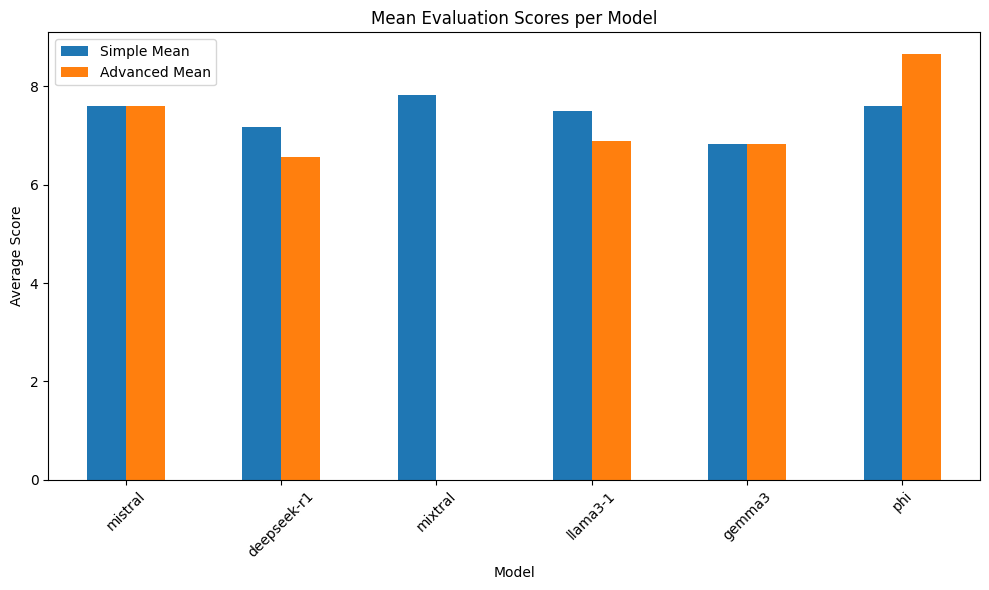

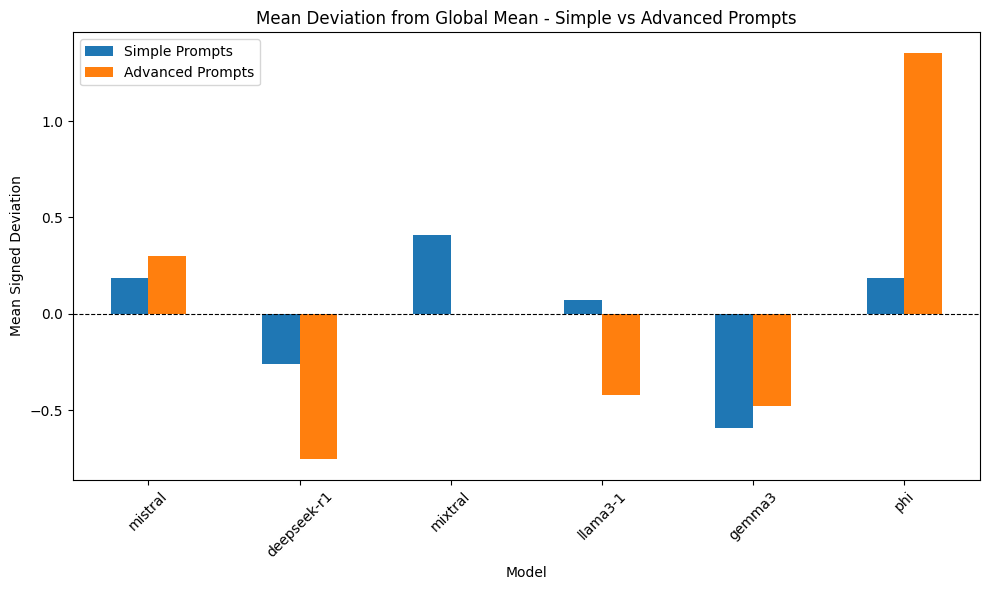

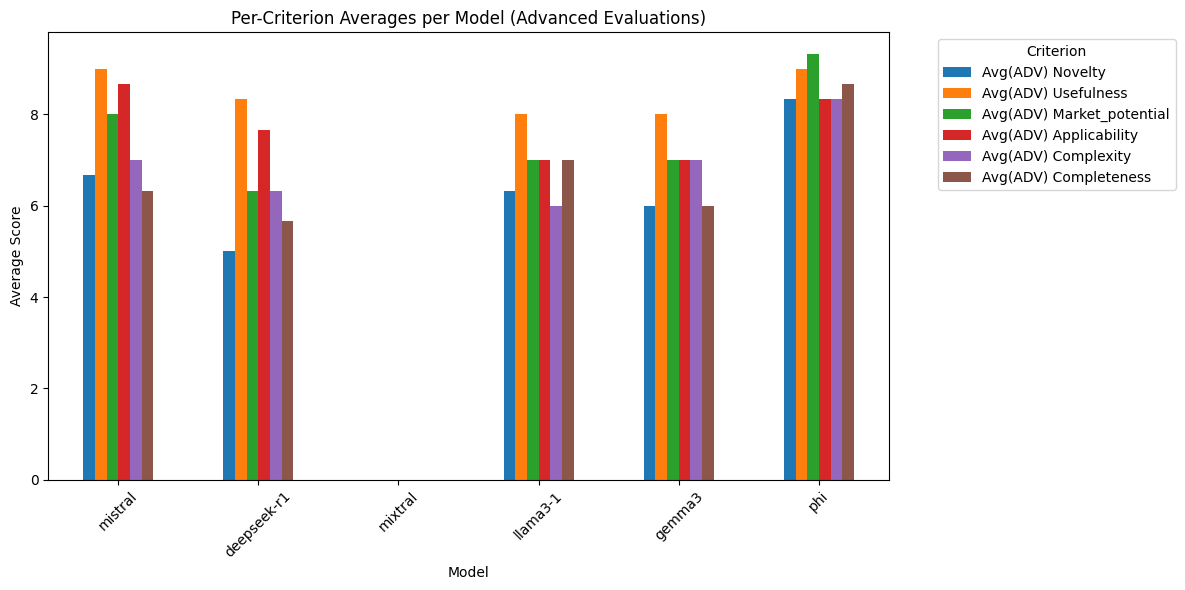

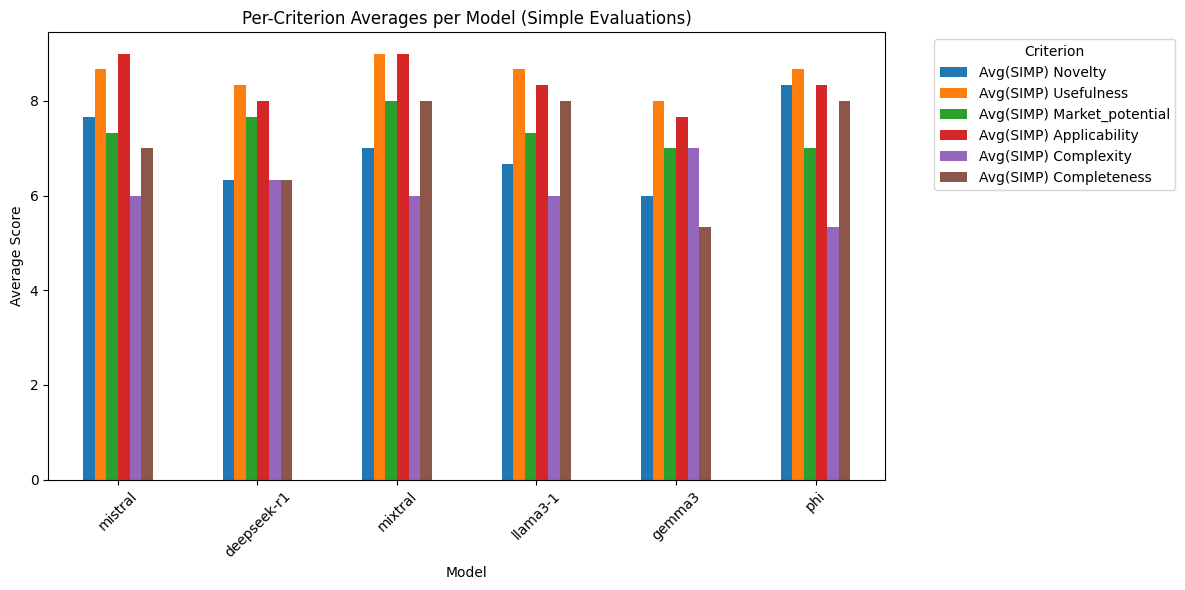

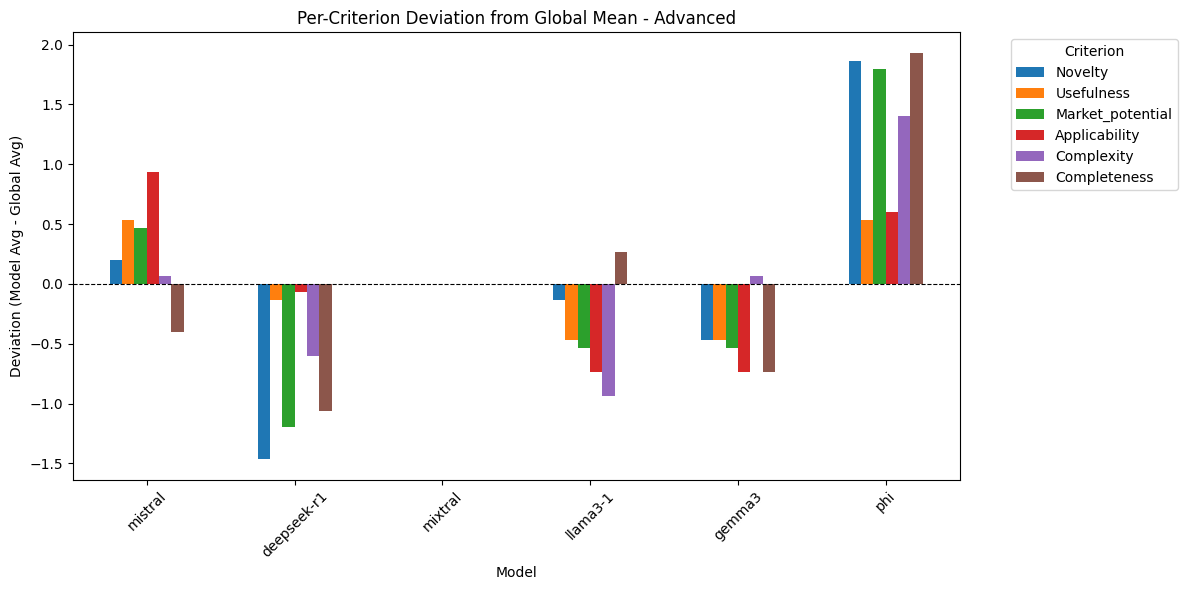

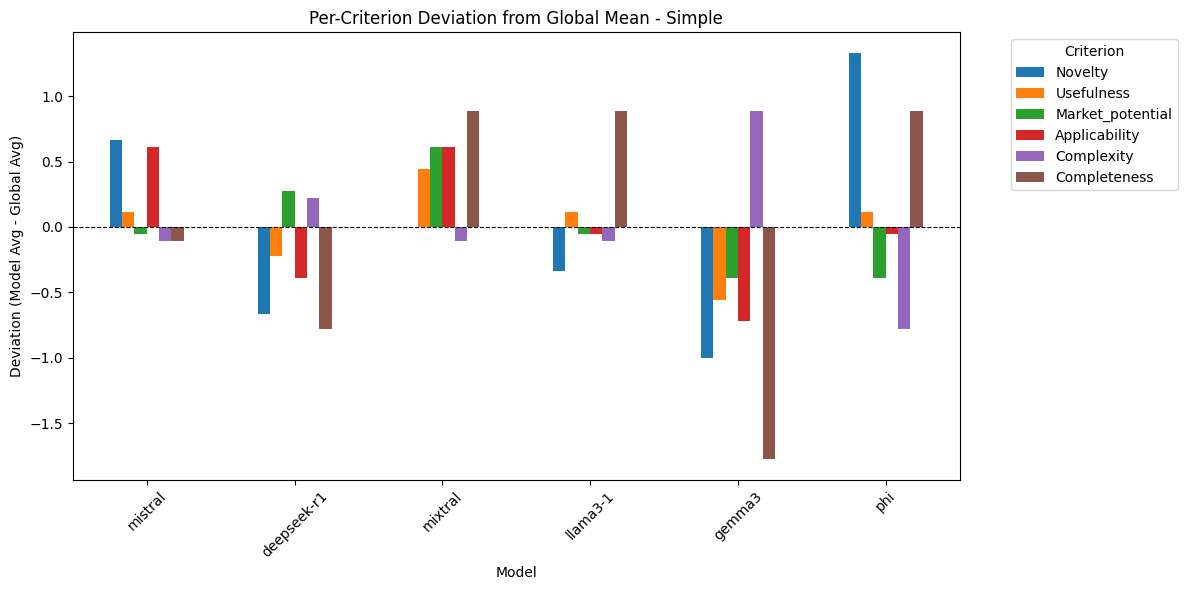

Intra-model comparison


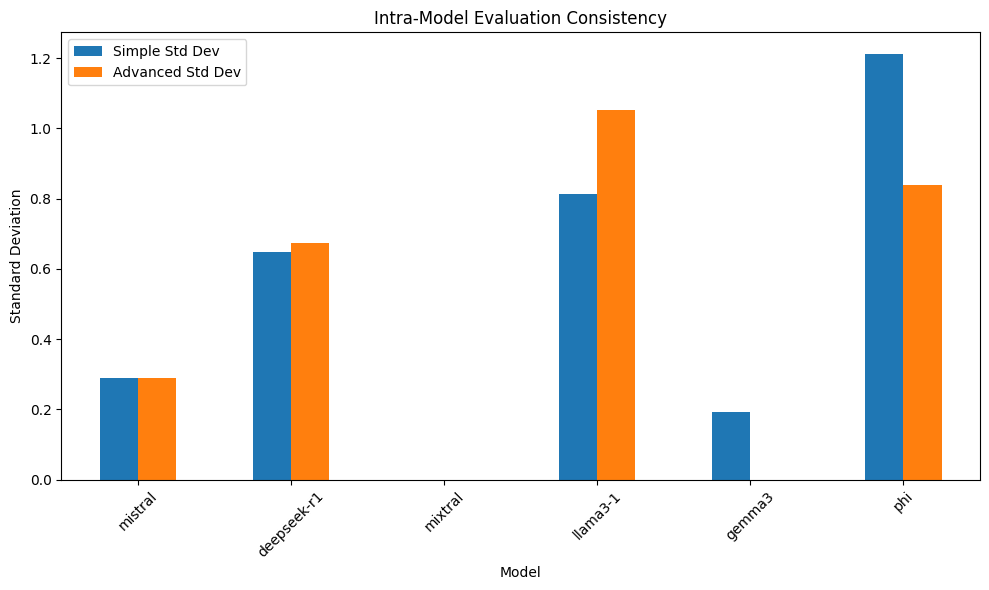

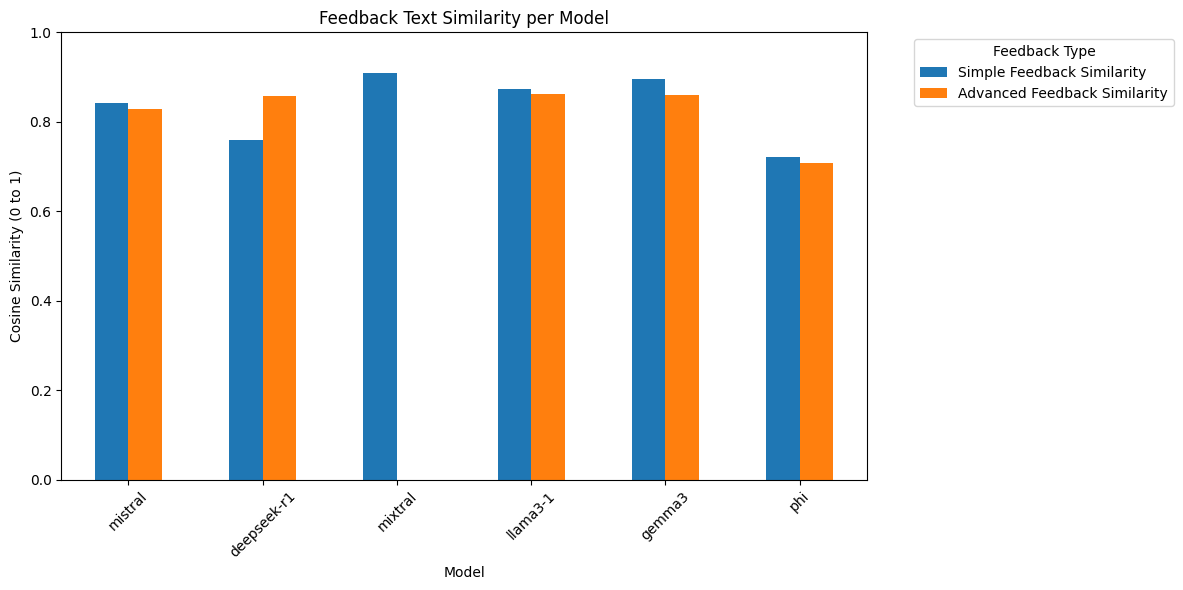

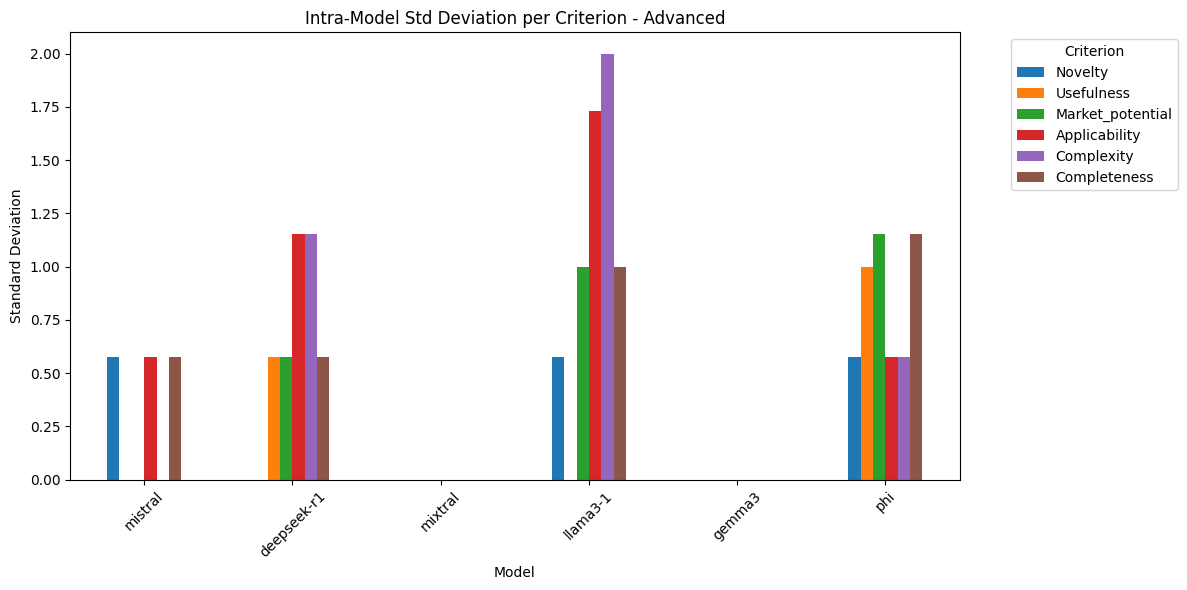

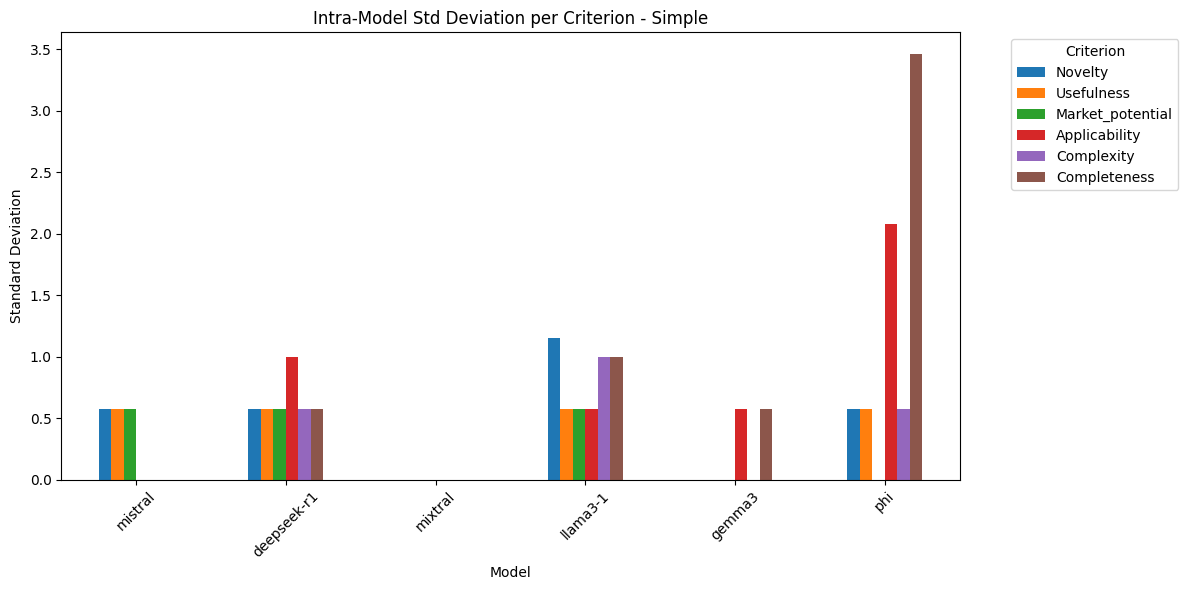

Summary


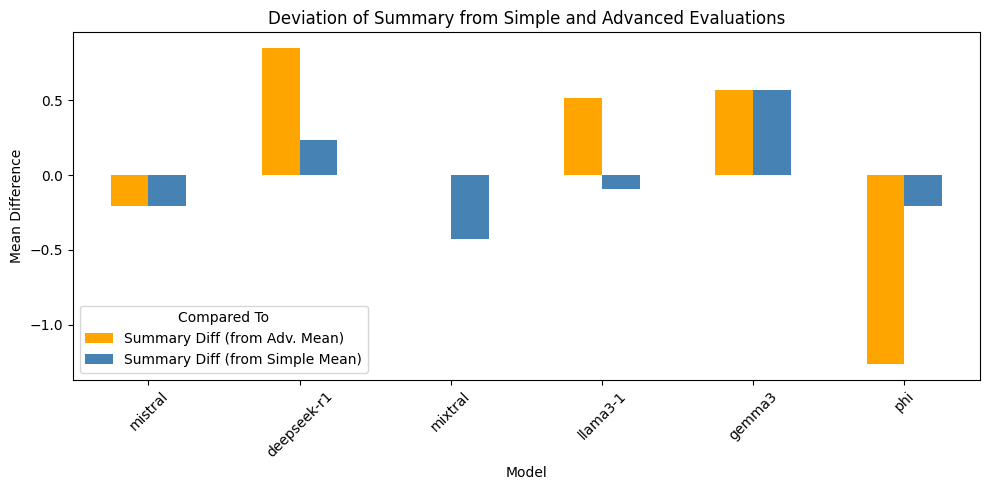

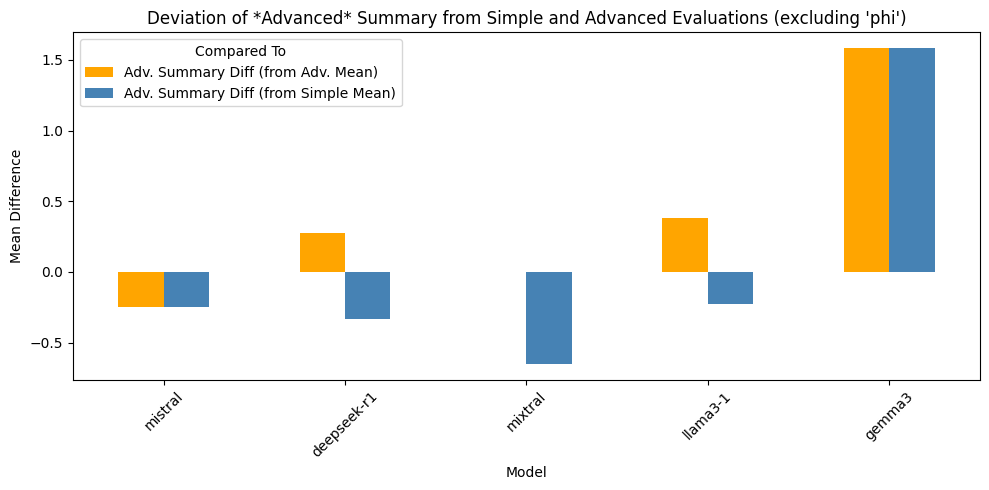

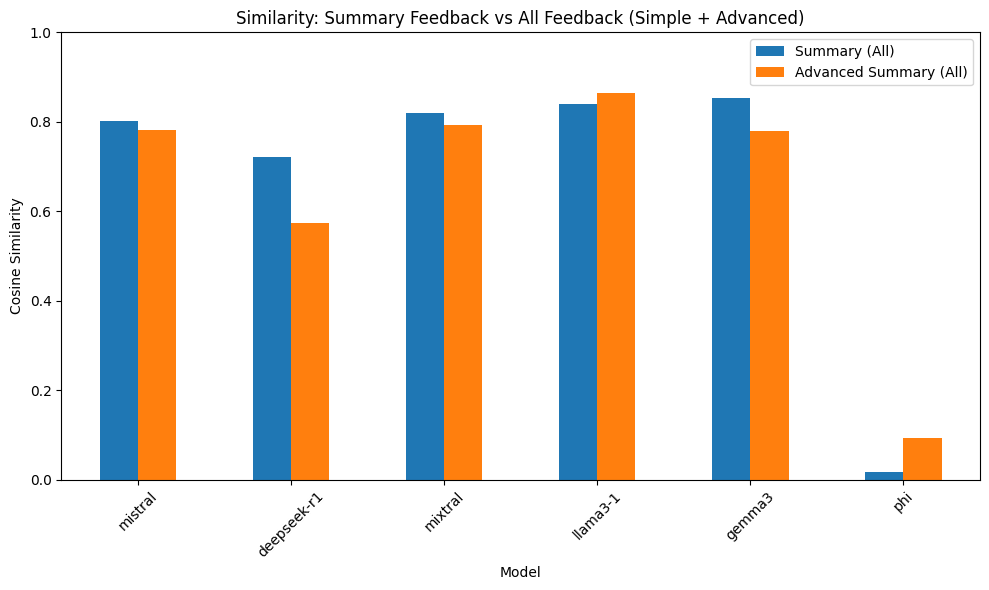

In [82]:
if __name__ == "__main__":
    models = {
        MISTRAL_ID: {
            "simple": MISTRAL_EVALUATIONS,
            "advanced": MISTRAL_ADVANCED_EVALUATIONS,
            "summary": MISTRAL_SUMMARY,
            "summary_adv": MISTRAL_ADVANCED_SUMMARY
        },
        DEEPSEEK_ID: {
            "simple": DEEPSEEK_EVALUATIONS,
            "advanced": DEEPSEEK_ADVANCED_EVALUATIONS,
            "summary": DEEPSEEK_SUMMARY,
            "summary_adv": DEEPSEEK_ADVANCED_SUMMARY
        },
        MIXTRAL_ID: {
            "simple": MIXTRAL_EVALUATIONS,
            "advanced": MIXTRAL_ADVANCED_EVALUATIONS,
            "summary": MIXTRAL_SUMMARY,
            "summary_adv": MIXTRAL_ADVANCED_SUMMARY
        },
        LLAMA3_1_ID: {
            "simple": LLAMA3_1_EVALUATIONS,
            "advanced": LLAMA3_1_ADVANCED_EVALUATIONS,
            "summary": LLAMA3_1_SUMMARY,
            "summary_adv": LLAMA3_1_ADVANCED_SUMMARY
        },
        GEMMA3_ID: {
            "simple": GEMMA3_EVALUATIONS,
            "advanced": GEMMA3_ADVANCED_EVALUATIONS,
            "summary": GEMMA3_SUMMARY,
            "summary_adv": GEMMA3_ADVANCED_SUMMARY
        },
        PHI_ID: {
            "simple": PHI_EVALUATIONS,
            "advanced": PHI_ADVANCED_EVALUATIONS,
            "summary": PHI_SUMMARY,
            "summary_adv": PHI_ADVANCED_SUMMARY
        }
    }

    results_df = evaluate_all(models)
    # For Advanced criteria
    results_df = compute_mean_criterion_deviation_from_global_mean(results_df, prefix="Avg(ADV)", name="Average(ADV)")

    # For Simple criteria
    results_df = compute_mean_criterion_deviation_from_global_mean(results_df, prefix="Avg(SIMP)", name="Average(SIMP)")

    # Display updated DataFrame
    print(results_df)

    # Compute per-model-per-criterion deviations
    adv_dev_table = compute_criterionwise_deviation_table(results_df, prefix="Avg(ADV)")
    simp_dev_table = compute_criterionwise_deviation_table(results_df, prefix="Avg(SIMP)")

    # View the advanced deviation table
    print(adv_dev_table)


    # Visualizations

    # Inter
    print("Inter-model comparison")
    plot_model_comparison(results_df)
    plot_combined_mean_deviation_from_global_mean(results_df)
    plot_criterion_averages(results_df)
    plot_criterionwise_deviation_table(adv_dev_table, prefix="Avg(ADV)")
    plot_criterionwise_deviation_table(simp_dev_table, prefix="Avg(SIMP)")

    # Intra
    print("Intra-model comparison")
    plot_std_devs(results_df)
    plot_feedback_similarities(results_df)
    plot_criterionwise_intra_std(results_df, prefix="Std(ADV)")
    plot_criterionwise_intra_std(results_df, prefix="Std(SIMP)")

    # Summary
    print("Summary")
    plot_summary_diffs(results_df)
    plot_summary_to_all_feedback_similarity(results_df)

## Low Quality Idea Evaluation
Here the data from the **Low Quality Idea Description** is examined and visualized.

         Model  Simple Std Dev  Advanced Std Dev  Simple Mean  Advanced Mean  \
0      mistral        0.769800          0.192450     7.333333       6.888889   
1  deepseek-r1        0.788675          1.602186     6.833333       6.333333   
2      mixtral        0.096225               NaN     7.111111            NaN   
3     llama3-1        0.096225          0.384900     7.222222       6.555556   
4       gemma3        0.000000          0.096225     6.333333       6.388889   
5          phi        1.069046          1.428163     6.666667       7.111111   

   Summary Diff (from Adv. Mean)  Summary Diff (from Simple Mean)  \
0                      -0.111111                        -0.555556   
1                       0.444444                        -0.055556   
2                            NaN                        -0.333333   
3                       0.222222                        -0.444444   
4                       0.388889                         0.444444   
5                      -0

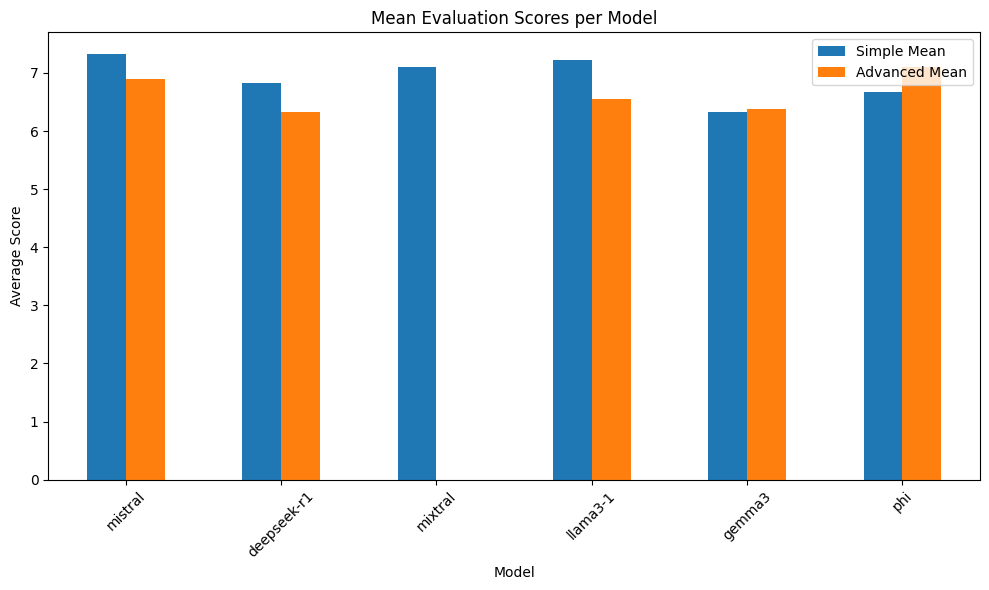

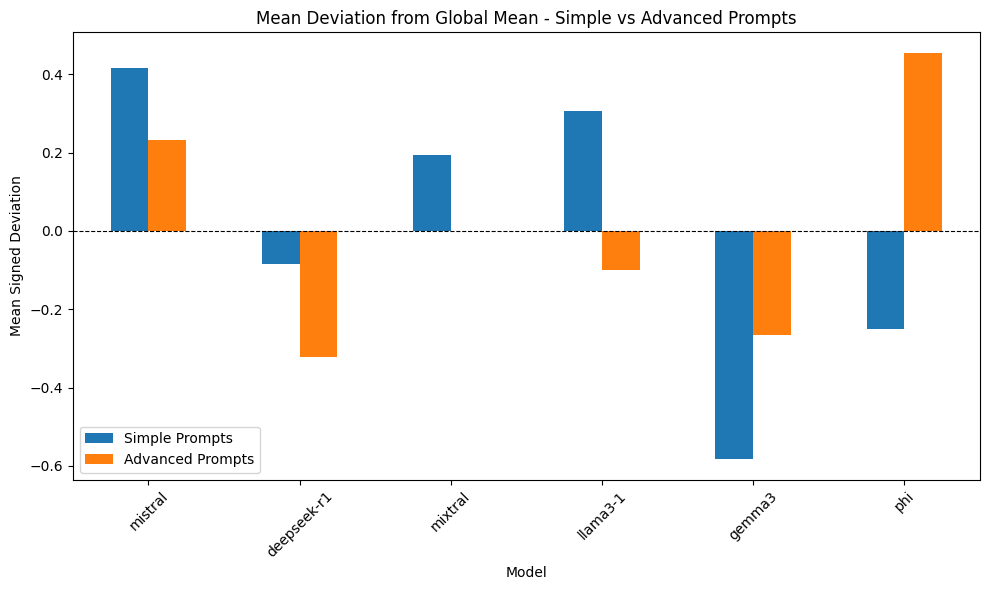

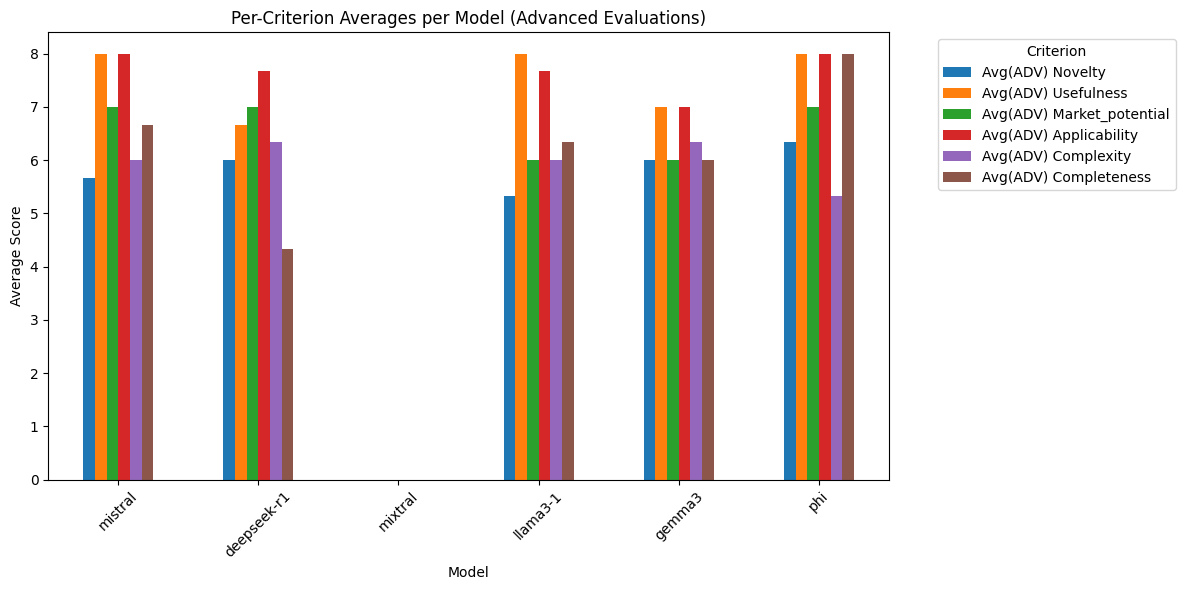

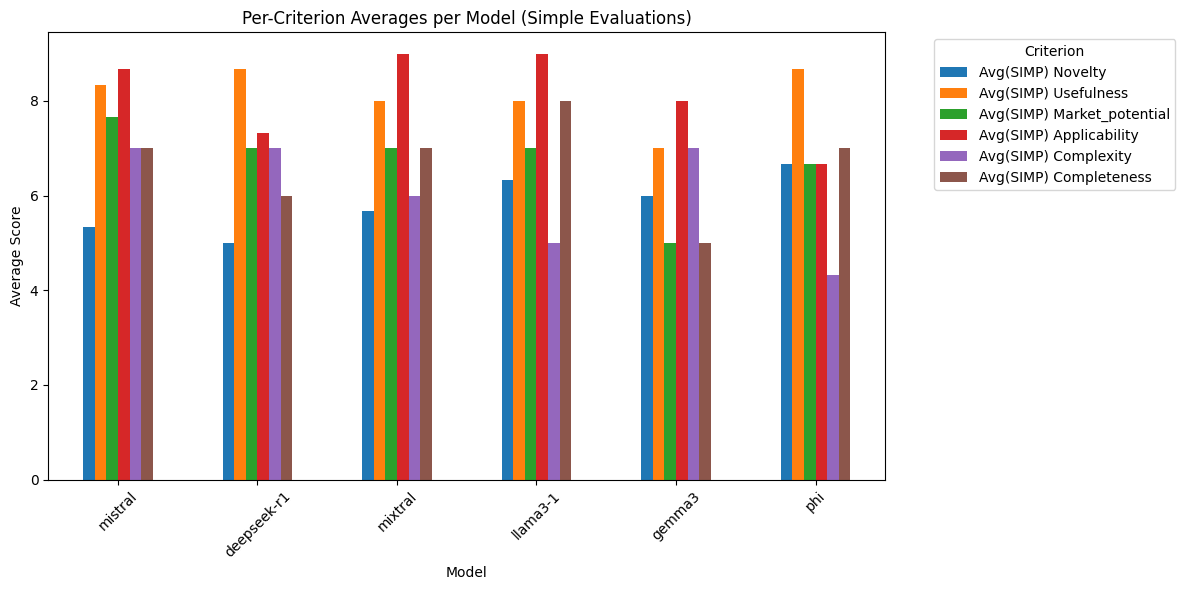

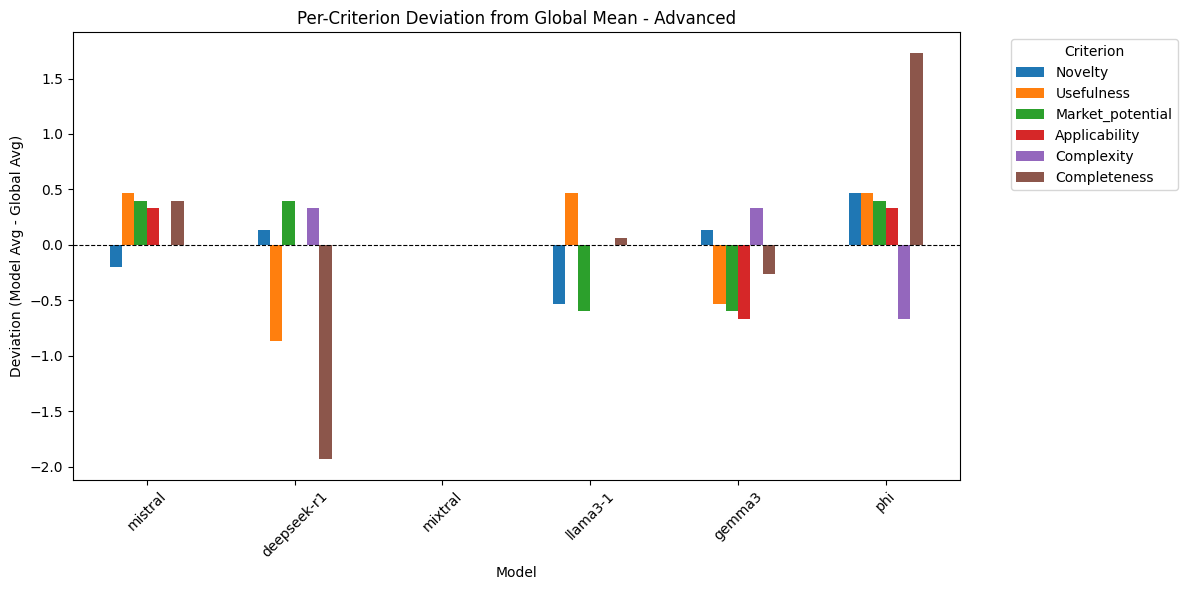

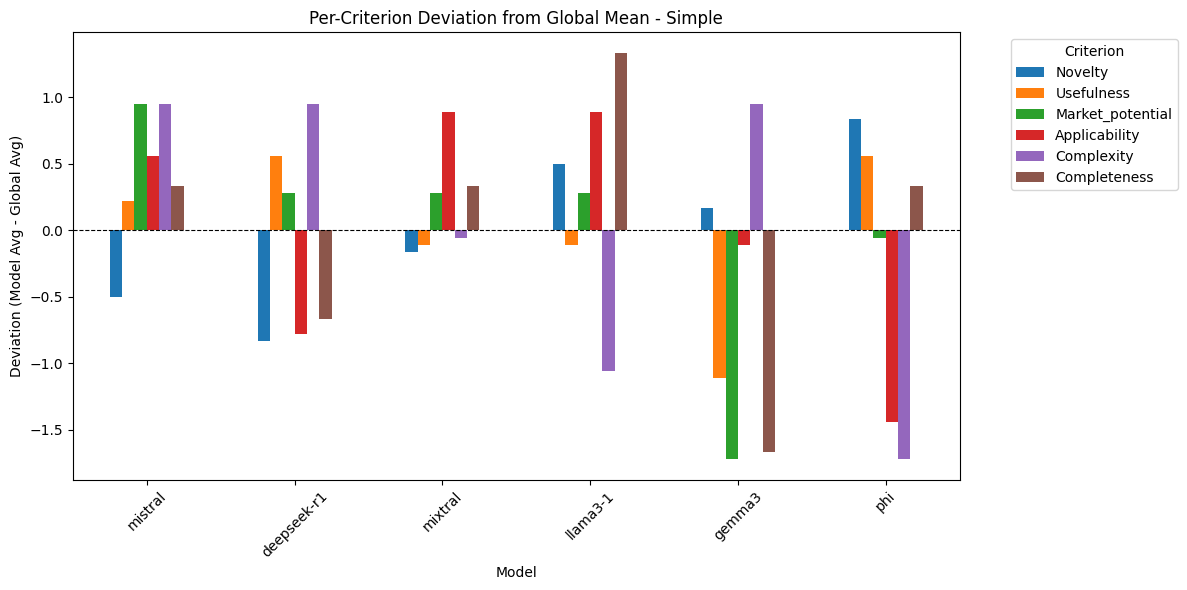

Intra-model comparison


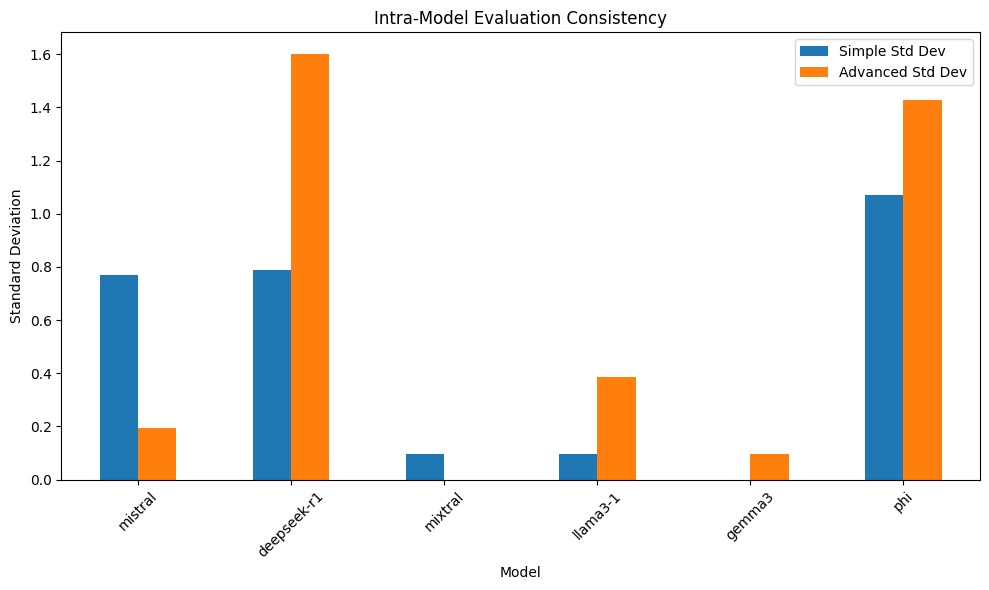

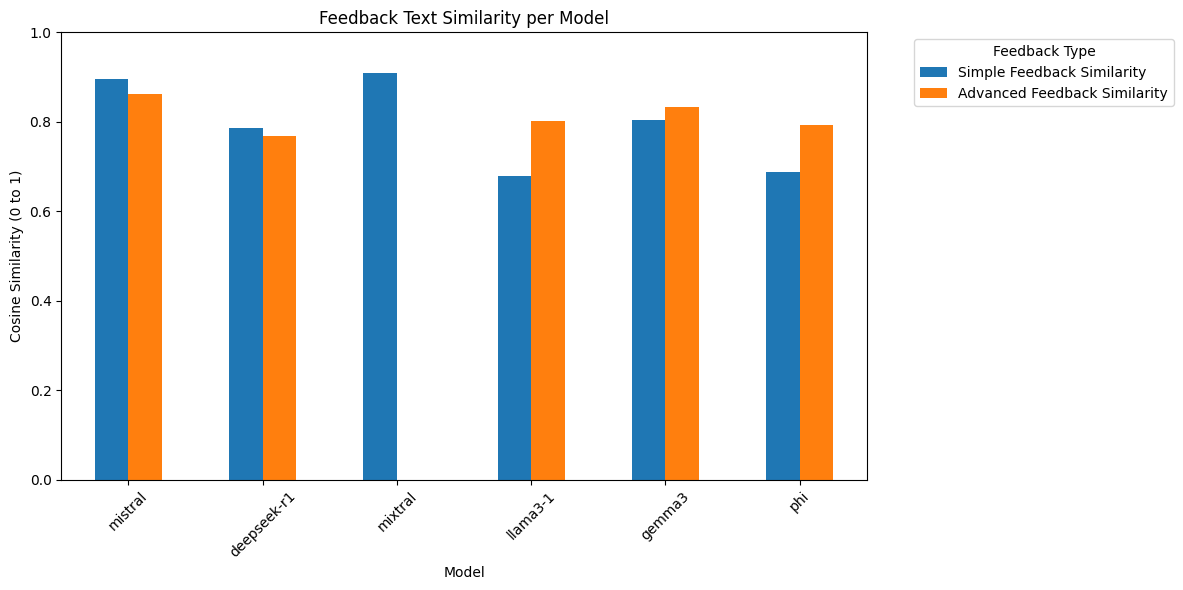

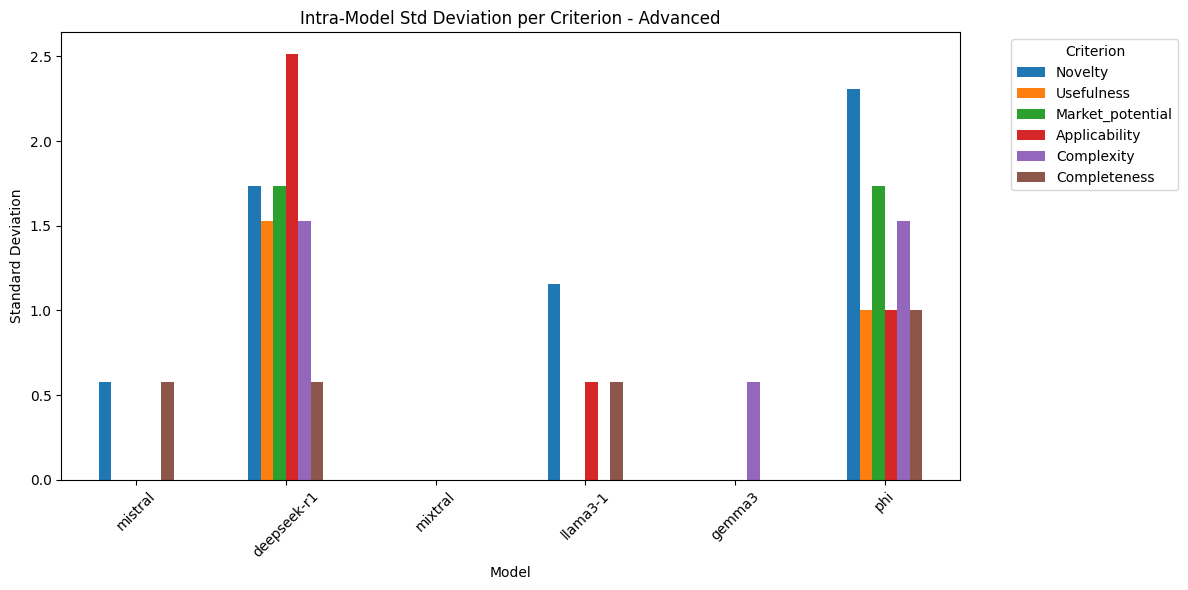

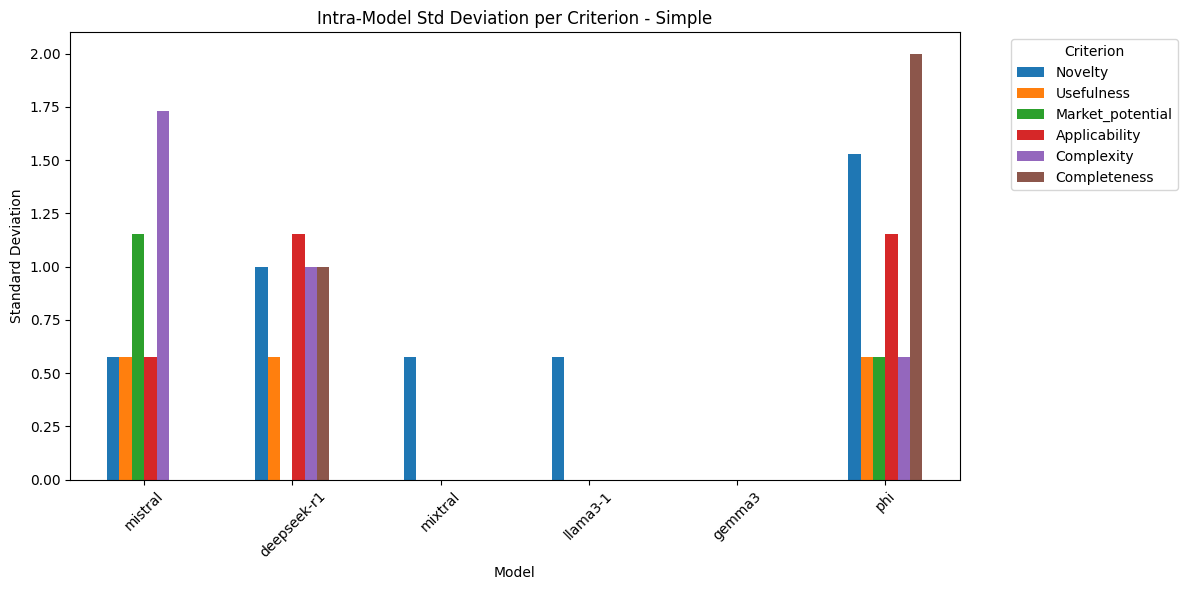

Summary


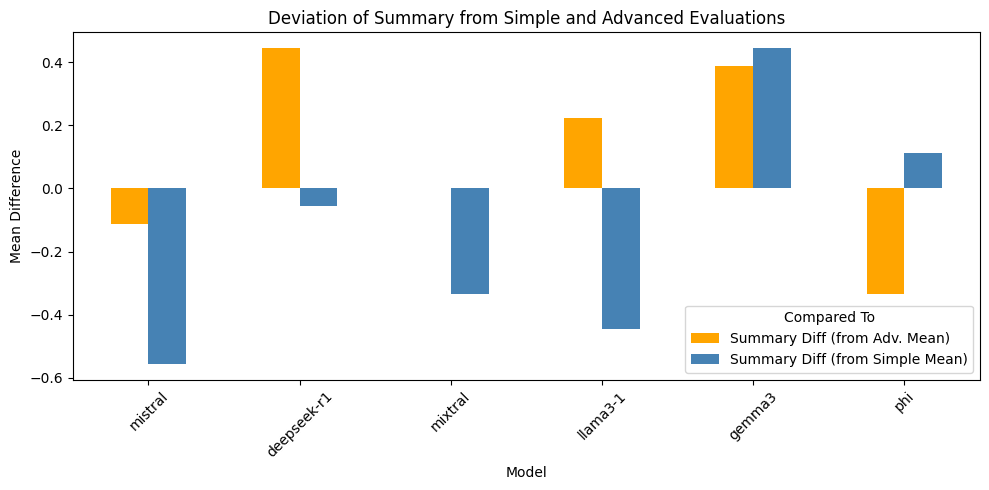

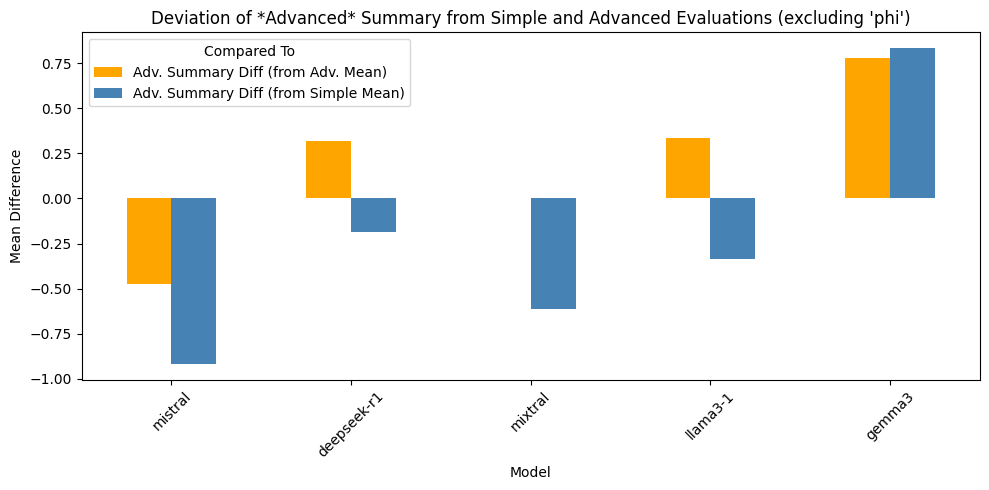

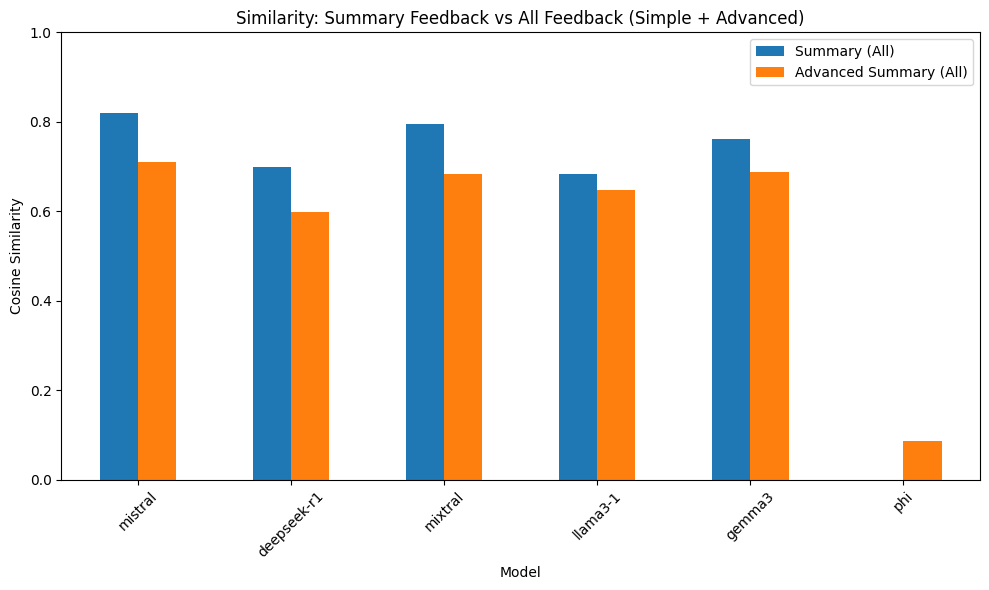

In [83]:
if __name__ == "__main__":
    models = {
        MISTRAL_ID: {
            "simple": MISTRAL_EVALUATIONS_2,
            "advanced": MISTRAL_ADVANCED_EVALUATIONS_2,
            "summary": MISTRAL_SUMMARY_2,
            "summary_adv": MISTRAL_ADVANCED_SUMMARY_2
        },
        DEEPSEEK_ID: {
            "simple": DEEPSEEK_EVALUATIONS_2,
            "advanced": DEEPSEEK_ADVANCED_EVALUATIONS_2,
            "summary": DEEPSEEK_SUMMARY_2,
            "summary_adv": DEEPSEEK_ADVANCED_SUMMARY_2
        },
        MIXTRAL_ID: {
            "simple": MIXTRAL_EVALUATIONS_2,
            "advanced": MIXTRAL_ADVANCED_EVALUATIONS_2,
            "summary": MIXTRAL_SUMMARY_2,
            "summary_adv": MIXTRAL_ADVANCED_SUMMARY_2
        },
        LLAMA3_1_ID: {
            "simple": LLAMA3_1_EVALUATIONS_2,
            "advanced": LLAMA3_1_ADVANCED_EVALUATIONS_2,
            "summary": LLAMA3_1_SUMMARY_2,
            "summary_adv": LLAMA3_1_ADVANCED_SUMMARY_2
        },
        GEMMA3_ID: {
            "simple": GEMMA3_EVALUATIONS_2,
            "advanced": GEMMA3_ADVANCED_EVALUATIONS_2,
            "summary": GEMMA3_SUMMARY_2,
            "summary_adv": GEMMA3_ADVANCED_SUMMARY_2
        },
        PHI_ID: {
            "simple": PHI_EVALUATIONS_2,
            "advanced": PHI_ADVANCED_EVALUATIONS_2,
            "summary": PHI_SUMMARY_2,
            "summary_adv": PHI_ADVANCED_SUMMARY_2
        }
    }

    results_df = evaluate_all(models)
    # For Advanced criteria
    results_df = compute_mean_criterion_deviation_from_global_mean(results_df, prefix="Avg(ADV)", name="Average(ADV)")

    # For Simple criteria
    results_df = compute_mean_criterion_deviation_from_global_mean(results_df, prefix="Avg(SIMP)", name="Average(SIMP)")

    # Display updated DataFrame
    print(results_df)

    # Compute per-model-per-criterion deviations
    adv_dev_table = compute_criterionwise_deviation_table(results_df, prefix="Avg(ADV)")
    simp_dev_table = compute_criterionwise_deviation_table(results_df, prefix="Avg(SIMP)")

    # View the advanced deviation table
    print(adv_dev_table)


    # Visualizations

    # Inter
    print("Inter-model comparison")
    plot_model_comparison(results_df)
    plot_combined_mean_deviation_from_global_mean(results_df)
    plot_criterion_averages(results_df)
    plot_criterionwise_deviation_table(adv_dev_table, prefix="Avg(ADV)")
    plot_criterionwise_deviation_table(simp_dev_table, prefix="Avg(SIMP)")

    # Intra
    print("Intra-model comparison")
    plot_std_devs(results_df)
    plot_feedback_similarities(results_df)
    plot_criterionwise_intra_std(results_df, prefix="Std(ADV)")
    plot_criterionwise_intra_std(results_df, prefix="Std(SIMP)")

    # Summary
    print("Summary")
    plot_summary_diffs(results_df)
    plot_summary_to_all_feedback_similarity(results_df)